In [1]:
import sys
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import ( preprocess_input, decode_predictions)
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import os

In [4]:
def load_and_display(img, size=224, display=0):
    #print('size: {}'.format(size))
    image = load_img(img, target_size=(size, size))
    if display:
        plt.imshow(image)
    return image
    
def process_img(image):
    image = img_to_array(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    image = preprocess_input(image)
    return image

def predict_class(image):
    model = VGG16()
    yhat = model.predict(image)
    label = decode_predictions(yhat)
    print('identified as : {} with a probability of {:.2f} '.format(label[0][0][1], label[0][0][2]))
    print('all guesses: {}'.format(label))

In [5]:
download_dir = Path('./gemstones')

In [6]:
download_dir

PosixPath('gemstones')

In [7]:
train_data_dir = download_dir/'train_orig'
test_data_dir = download_dir/'test_orig'

#class_subset = sorted(os.listdir(download_dir/'train'))[:6]
class_subset = sorted(os.listdir(download_dir/'train_orig'))


In [8]:
class_subset

['Alexandrite',
 'Almandine',
 'Amazonite',
 'Amber',
 'Amethyst',
 'Ametrine',
 'Andalusite',
 'Andradite',
 'Aquamarine',
 'Aventurine Green',
 'Aventurine Yellow',
 'Benitoite',
 'Beryl Golden',
 'Bixbite',
 'Bloodstone',
 'Blue Lace Agate',
 'Carnelian',
 'Cats Eye',
 'Chalcedony',
 'Chalcedony Blue',
 'Chrome Diopside',
 'Chrysoberyl',
 'Chrysocolla',
 'Chrysoprase',
 'Citrine',
 'Coral',
 'Danburite',
 'Diamond',
 'Diaspore',
 'Dumortierite',
 'Emerald',
 'Fluorite',
 'Garnet Red',
 'Goshenite',
 'Grossular',
 'Hessonite',
 'Hiddenite',
 'Iolite',
 'Jade',
 'Jasper',
 'Kunzite',
 'Kyanite',
 'Labradorite',
 'Lapis Lazuli',
 'Larimar',
 'Malachite',
 'Moonstone',
 'Morganite',
 'Onyx Black',
 'Onyx Green',
 'Onyx Red',
 'Opal',
 'Pearl',
 'Peridot',
 'Prehnite',
 'Pyrite',
 'Pyrope',
 'Quartz Beer',
 'Quartz Lemon',
 'Quartz Rose',
 'Quartz Rutilated',
 'Quartz Smoky',
 'Rhodochrosite',
 'Rhodolite',
 'Rhodonite',
 'Ruby',
 'Sapphire Blue',
 'Sapphire Pink',
 'Sapphire Purple',
 '

In [9]:
#BATCH_SIZE = 5
BATCH_SIZE = 10

In [10]:
train_generator = ImageDataGenerator(rotation_range=90, 
                                     #rescale = 1./255,
                                     #zoom_range = 0.2,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(
    # rescale=1./255, 
    preprocessing_function=preprocess_input) # VGG16 preprocessing

In [11]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

Found 2470 images belonging to 87 classes.


In [12]:
validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 386 images belonging to 87 classes.
Found 363 images belonging to 87 classes.


In [13]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.00001)
#n_classes=6
n_classes = 87

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [15]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
from tensorflow import keras

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [17]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/50
247/247 [==============================] - ETA: 0s - loss: 7.7639 - accuracy: 0.0356
Epoch 00001: val_loss improved from inf to 5.56566, saving model to tl_model_v1.weights.best.hdf5
247/247 [==============================] - 32s 128ms/step - loss: 7.7639 - accuracy: 0.0356 - val_loss: 5.5657 - val_accuracy: 0.0368
Epoch 2/50
247/247 [==============================] - ETA: 0s - loss: 5.1179 - accuracy: 0.0911
Epoch 00002: val_loss improved from 5.56566 to 4.44921, saving model to tl_model_v1.weights.best.hdf5
247/247 [==============================] - 32s 128ms/step - loss: 5.1179 - accuracy: 0.0911 - val_loss: 4.4492 - val_accuracy: 0.1132
Epoch 3/50
247/247 [==============================] - ETA: 0s - loss: 4.2188 - accuracy: 0.1417
Epoch 00003: val_loss improved from 4.44921 to 4.02123, saving model to tl_model_v1.weights.best.hdf5
247/247 [==============================] - 34s 136ms/step - loss: 4.2188 - accuracy: 0.1417 - val_loss: 4.0212 - val_accuracy: 0.1316
Epoch 4/

Epoch 27/50
247/247 [==============================] - ETA: 0s - loss: 1.5599 - accuracy: 0.5854
Epoch 00027: val_loss improved from 2.17688 to 2.16134, saving model to tl_model_v1.weights.best.hdf5
247/247 [==============================] - 36s 145ms/step - loss: 1.5599 - accuracy: 0.5854 - val_loss: 2.1613 - val_accuracy: 0.4526
Epoch 28/50
247/247 [==============================] - ETA: 0s - loss: 1.5308 - accuracy: 0.5773
Epoch 00028: val_loss did not improve from 2.16134
247/247 [==============================] - 33s 134ms/step - loss: 1.5308 - accuracy: 0.5773 - val_loss: 2.2866 - val_accuracy: 0.4105
Epoch 29/50
247/247 [==============================] - ETA: 0s - loss: 1.5664 - accuracy: 0.5619
Epoch 00029: val_loss did not improve from 2.16134
247/247 [==============================] - 33s 133ms/step - loss: 1.5664 - accuracy: 0.5619 - val_loss: 2.1689 - val_accuracy: 0.4842
Epoch 30/50
247/247 [==============================] - ETA: 0s - loss: 1.4908 - accuracy: 0.5822
Epoch 

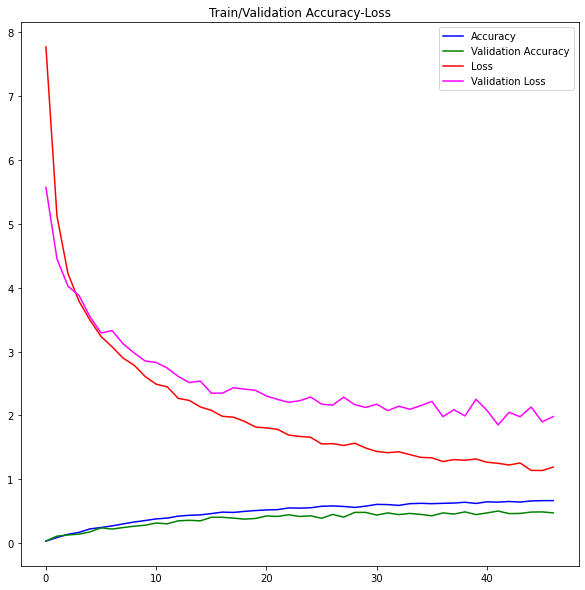

In [18]:
#Plot the loss + Accuracy
hist = vgg_history
epochs = range(len(hist.history['accuracy']))
acc = hist.history['accuracy']
loss = hist.history['loss']
                    
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
                        
plt.figure(figsize=(10,10))
plt.plot(epochs, acc, c='blue', label='Accuracy')  
plt.plot(epochs, val_acc, c='green', label='Validation Accuracy')
plt.plot(epochs, loss, c='red', label='Loss')
plt.plot(epochs, val_loss, c='magenta', label='Validation Loss') 
                        
plt.title('Train/Validation Accuracy-Loss')
plt.legend()
plt.show()
                 

In [19]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

In [20]:
true_classes, class_indices

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
         4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
        12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16,
        16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20,
        20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24,
        24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28,
        28, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32,
        32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36,
        37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40,
        41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44,
        45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48,
        49, 49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 52, 52, 52,
        53, 

In [21]:
testgen.classes

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
       12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16,
       16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24,
       24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28,
       28, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32,
       32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36,
       37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40,
       41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44,
       45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48,
       49, 49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 52, 52, 52,
       53, 53, 53, 53, 53

In [22]:
def custom_predict(base_dir, verbose=0):
    mislabels = []
    succ_cnt = fail_cnt = 0
    list_of_labels = os.listdir(base_dir)
    for label in list_of_labels:
        curr_label_dir_path = os.path.join(base_dir, label)
        img_list = os.listdir(curr_label_dir_path)
        for img_name in img_list:
            curr_img_path = os.path.join(curr_label_dir_path, img_name)
            img = load_and_display(curr_img_path)
            img = img_to_array(img)
            img = process_img(img)
            vgg_preds = vgg_model.predict(img, verbose=verbose)
            vgg_pred_classes = np.argmax(vgg_preds, axis=1)
            pred_class = vgg_pred_classes.tolist()[0]
            pred_label = class_indices[pred_class]
            if pred_label != label:
                fail_cnt += 1
                succ = False
                mislabels.append((img_name, label, pred_label))
            else:
                succ_cnt += 1
                succ = True
            print('status: {} img: {}, label: {} predicted {} - {}'.format(
                succ, img_name, label, pred_class, class_indices[pred_class]))
            
    total = succ_cnt + fail_cnt
    print('========================================')
    print('Fail count : {} total: {} succ percentage: {}'.format(fail_cnt, total, (succ_cnt/total) * 100))
    print('========================================')
    
    if len(mislabels) > 0:
        print('The following were predicted incorrectly:')
        for el in mislabels:
            print('file name: {} True label: {} Predicted: {}'.format(el[0], el[1], el[2]))

In [23]:
custom_predict('./gemstones/test_orig', verbose=0)

status: True img: alexandrite_3.jpg, label: Alexandrite predicted 0 - Alexandrite
status: True img: alexandrite_28.jpg, label: Alexandrite predicted 0 - Alexandrite
status: True img: alexandrite_18.jpg, label: Alexandrite predicted 0 - Alexandrite
status: False img: alexandrite_6.jpg, label: Alexandrite predicted 36 - Hiddenite
status: True img: quartz rose_5.jpg, label: Quartz Rose predicted 59 - Quartz Rose
status: True img: quartz rose_18.jpg, label: Quartz Rose predicted 59 - Quartz Rose
status: True img: quartz rose_7.jpg, label: Quartz Rose predicted 59 - Quartz Rose
status: False img: quartz rose_3.jpg, label: Quartz Rose predicted 19 - Chalcedony Blue
status: False img: rhodolite_3.jpg, label: Rhodolite predicted 67 - Sapphire Pink
status: False img: rhodolite_6.jpg, label: Rhodolite predicted 4 - Amethyst
status: False img: rhodolite_9.jpg, label: Rhodolite predicted 67 - Sapphire Pink
status: False img: rhodolite_4.jpg, label: Rhodolite predicted 67 - Sapphire Pink
status: Fa

status: False img: chrysoprase_3.jpg, label: Chrysoprase predicted 49 - Onyx Green
status: True img: chrysoprase_28.jpg, label: Chrysoprase predicted 23 - Chrysoprase
status: True img: dumortierite_18.jpg, label: Dumortierite predicted 29 - Dumortierite
status: False img: dumortierite_28.jpg, label: Dumortierite predicted 83 - Turquoise
status: True img: dumortierite_3.jpg, label: Dumortierite predicted 29 - Dumortierite
status: True img: dumortierite_8.jpg, label: Dumortierite predicted 29 - Dumortierite
status: True img: benitoite_28.jpg, label: Benitoite predicted 11 - Benitoite
status: True img: benitoite_9.jpg, label: Benitoite predicted 11 - Benitoite
status: False img: benitoite_3.jpg, label: Benitoite predicted 78 - Tanzanite
status: True img: benitoite_18.jpg, label: Benitoite predicted 11 - Benitoite
status: True img: turquoise_18.jpg, label: Turquoise predicted 83 - Turquoise
status: True img: turquoise_28.jpg, label: Turquoise predicted 83 - Turquoise
status: True img: turq

status: True img: pyrite_7.jpg, label: Pyrite predicted 55 - Pyrite
status: True img: pyrite_4.jpg, label: Pyrite predicted 55 - Pyrite
status: True img: sunstone_30.jpg, label: Sunstone predicted 77 - Sunstone
status: False img: sunstone_3.jpg, label: Sunstone predicted 25 - Coral
status: True img: sunstone_32.jpg, label: Sunstone predicted 77 - Sunstone
status: True img: sunstone_18.jpg, label: Sunstone predicted 77 - Sunstone
status: False img: chalcedony blue_3.jpg, label: Chalcedony Blue predicted 44 - Larimar
status: False img: chalcedony blue_2.jpg, label: Chalcedony Blue predicted 44 - Larimar
status: True img: chalcedony blue_28.jpg, label: Chalcedony Blue predicted 19 - Chalcedony Blue
status: True img: chalcedony blue_18.jpg, label: Chalcedony Blue predicted 19 - Chalcedony Blue
status: False img: citrine_41.jpg, label: Citrine predicted 21 - Chrysoberyl
status: False img: citrine_42.jpg, label: Citrine predicted 74 - Sphene
status: False img: citrine_3.jpg, label: Citrine p

status: False img: tourmaline_4.jpg, label: Tourmaline predicted 67 - Sapphire Pink
status: True img: hessonite_2.jpg, label: Hessonite predicted 35 - Hessonite
status: True img: hessonite_28.jpg, label: Hessonite predicted 35 - Hessonite
status: False img: hessonite_3.jpg, label: Hessonite predicted 32 - Garnet Red
status: False img: hessonite_18.jpg, label: Hessonite predicted 32 - Garnet Red
status: True img: scapolite_25.jpg, label: Scapolite predicted 70 - Scapolite
status: True img: scapolite_8.jpg, label: Scapolite predicted 70 - Scapolite
status: True img: scapolite_9.jpg, label: Scapolite predicted 70 - Scapolite
status: False img: scapolite_3.jpg, label: Scapolite predicted 14 - Bloodstone
status: True img: aventurine yellow_28.jpg, label: Aventurine Yellow predicted 10 - Aventurine Yellow
status: True img: aventurine yellow_3.jpg, label: Aventurine Yellow predicted 10 - Aventurine Yellow
status: True img: aventurine yellow_18.jpg, label: Aventurine Yellow predicted 10 - Aven

The pre-trained model used as a feature extractor, correctly predicted 57.85% of the test images.
* a learning_rate of 0.001 gave only 23% successful predictions;
* reducing the learning_rate to 0.00001 increased the successful predictions to 57.85%

In [24]:
traingen.reset()
validgen.reset()
testgen.reset()

In [ ]:
#vgg_preds = vgg_model.predict(testgen, verbose=1)
#vgg_pred_classes = np.argmax(vgg_preds, axis=1)